In [53]:
import torch
import torchvision ## Contains some utilities for working with the image data
from torchvision.datasets import FashionMNIST
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import random_split
from torch.utils.data import DataLoader
import torch.nn.functional as F
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import pandas as pd

#%matplotlib inline


In [38]:
class_names = [
    'T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 
    'Shirt', 'Sneaker', 'Bag', 'Ankle boot'
]


In [56]:
dataset = FashionMNIST(root='/tmp', train=True, download=True)
df = pd.DataFrame(dataset.data.numpy().reshape(-1, 28*28))

print(len(dataset))


60000


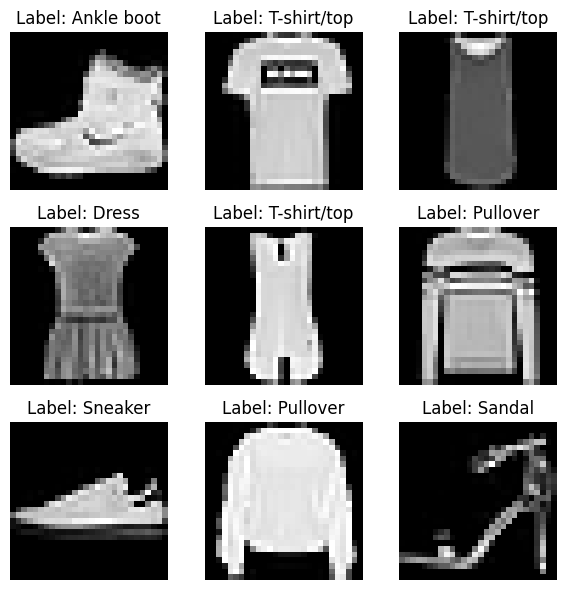

In [40]:
# Plotting 9 images in a 3x3 grid
fig, axes = plt.subplots(3, 3, figsize=(6, 6))
for i, ax in enumerate(axes.flat):
    image, label = dataset[i]
    ax.imshow(image, cmap='gray')  # Squeeze to remove single channel dimension
    ax.set_title(f"Label: {class_names[label]}")
    ax.axis('off')

plt.tight_layout()
plt.show()


In [41]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))  # Normalize images to have mean=0.5 and std=0.5
])

train_dataset = datasets.FashionMNIST(root='/tmp', train=True, download=False, transform=transform)
test_dataset = datasets.FashionMNIST(root='/tmp', train=False, download=False, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)


In [42]:
# https://www.kaggle.com/code/pankajj/fashion-mnist-with-pytorch-93-accuracy
class FashionCNN(nn.Module):
    def __init__(self):
        super(FashionCNN, self).__init__()
        
        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        
        self.layer2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        
        self.fc1 = nn.Linear(in_features=64*6*6, out_features=600)
        self.drop = nn.Dropout2d(0.25)
        self.fc2 = nn.Linear(in_features=600, out_features=120)
        self.fc3 = nn.Linear(in_features=120, out_features=10)
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.view(out.size(0), -1)
        out = self.fc1(out)
        out = self.drop(out)
        out = self.fc2(out)
        out = self.fc3(out)
        
        return out


In [43]:
model = FashionCNN()
criterion = nn.CrossEntropyLoss() 
optimizer = optim.Adam(model.parameters(), lr=0.001)

scheduler = ReduceLROnPlateau(optimizer, factor=0.1, patience=3, verbose=True)

epochs = 5

for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for images, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    scheduler.step(running_loss)

    print(
        f"Epoch {epoch+1}/{epochs}, Loss: {running_loss/len(train_loader):.4f}, Accuracy: {100 * correct/total:.2f}%"
    )


Epoch 1/5, Loss: 0.4307, Accuracy: 84.91%
Epoch 2/5, Loss: 0.2962, Accuracy: 89.39%
Epoch 3/5, Loss: 0.2564, Accuracy: 90.77%
Epoch 4/5, Loss: 0.2315, Accuracy: 91.63%
Epoch 5/5, Loss: 0.2107, Accuracy: 92.36%


In [44]:
model.eval()
correct = 0
total = 0

with torch.no_grad():
    for images, labels in test_loader:
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f"Test Accuracy: {100 * correct / total:.2f}%")


Test Accuracy: 90.85%


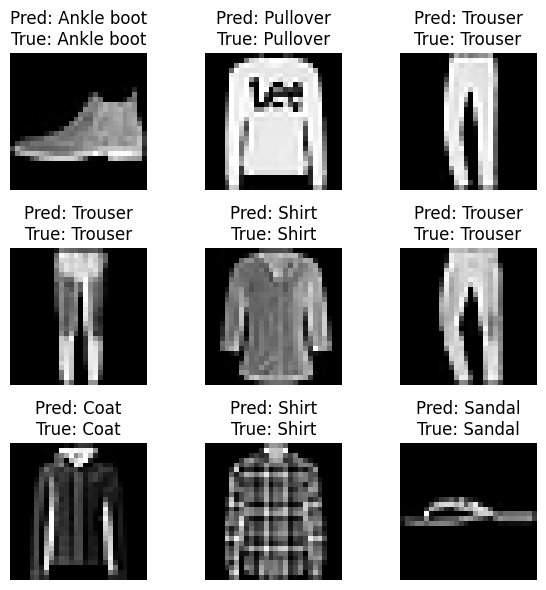

In [45]:
data_iter = iter(test_loader)
images, labels = next(data_iter)

with torch.no_grad():
    outputs = model(images)
    _, predictions = torch.max(outputs, 1)

fig, axes = plt.subplots(3, 3, figsize=(6, 6))
for i, ax in enumerate(axes.flat):
    ax.imshow(images[i][0], cmap='gray') 
    ax.set_title(f"Pred: {class_names[predictions[i]]}\nTrue: {class_names[labels[i]]}")
    ax.axis('off')

plt.tight_layout()
plt.show()


In [ ]:
from carla import Data

# Custom data set implementations need to inherit from the Data interface
class MyOwnDataSet(Data):
    def __init__(self, dataset):
        # The data set can e.g. be loaded in the constructor
        self._dataset = dataset

    # List of all categorical features
    @property
    def categorical(self):
        return [...]

    # List of all continuous features
    @property
    def continuous(self):
        return [...]

    # List of all immutable features which
    # should not be changed by the recourse method
    @property
    def immutables(self):
        return [...]

    # Feature name of the target column
    @property
    def target(self):
        return "label"

    # The full dataset
    @property
    def df(self):
        return self._dataset

    # The training split of the dataset
    @property
    def df_train(self):
        return self._dataset_train

    # The test split of the dataset
    @property
    def df_test(self):
         return self._dataset_test

    # Data transformation, for example normalization of continuous features
    # and encoding of categorical features
    def transform(self, df):
         return transformed_df

    # Inverts transform operation
    def inverse_transform(self, df):
         return original_df


In [58]:
from carla import MLModel

class FashionMNISTModel(MLModel):
    def __init__(self, data):
        super().__init__(data)
        self._mymodel = model  # The trained FashionMNIST model

    @property
    def feature_input_order(self):
        return ['pixel_' + str(i) for i in range(28 * 28)]

    @property
    def backend(self):
        return "pytorch"

    @property
    def raw_model(self):
        return self._mymodel

    def predict(self, x):
        return self._mymodel.predict(x)

    def predict_proba(self, x):
        return self._mymodel.predict(x)


In [61]:
carla_model = FashionMNISTModel(data=dataset.data.numpy().reshape(-1, 28*28))
carla_model._mymodel = model


In [63]:
from carla.models.negative_instances import predict_negative_instances
import carla.recourse_methods.catalog as recourse_catalog

hyperparams = {
    "data_name": "FashionMNIST",
    "n_search_samples": 100,
    "p_norm": 1,
    "step": 0.1,
    "max_iter": 1000,
    "clamp": True,
    "binary_cat_features": True,
    "vae_params": {
        "layers": [11, 512, 256, 8],
        "train": True,
        "lambda_reg": 1e-6,
        "epochs": 5,
        "lr": 1e-3,
        "batch_size": 32,
    },
}

cchvae = recourse_catalog.CCHVAE(carla_model, hyperparams)
df_cfs = cchvae.get_counterfactuals(carla_model)

display(df_cfs)


AttributeError: 'numpy.ndarray' object has no attribute 'df'